<center> <a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/10-SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> </center>

#<h1>SOM: Self-Organizing Map</h1>

En esta notebook se ilustra brevemente el funcionamiento y algunos usos de las SOMs. Para esto, usaremos el módulo `minisom`.

Para entrenar redes SOM usando este módulo no es necesario, usualmente, tener GPU.

[Documentación](https://github.com/JustGlowing/minisom)

<img align="left" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/img/SOM-training-2.png?raw=1"/>

In [ ]:
!pip install -q minisom

  Preparing metadata (setup.py) ... done


Referencias:

* Berglund, E., & Sitte, J. (2006). The parameterless self-organizing map algorithm. IEEE Transactions on neural networks, 17(2), 305-316.
* Yin, H. (2008). The self-organizing maps: Background, theories, extensions and applications. In Studies in Computational Intelligence. Stud. Comput. Intell. (Vol. 115, pp. 715-762). Springer Nature. https://doi.org/10.1007/978-3-540-78293-3_17

# Ejemplo 1: Demostración básica

En este ejemplo analizaremos datos de tarjetas de crédito de direferentes clientes, los datos están divididos en dos clases. En este ejemplo ilustraremos el funcionamiento de una SOM.

Traemos el dataset desde Github

In [ ]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/03-Deep-Learning/data/Credit_Card_Applications.csv"
!wget --no-cache --backups=1 --progress="dot" {url}

In [ ]:
import pandas as pd

df = pd.read_csv('Credit_Card_Applications.csv')
df

Separamos en el conjunto de datos y el vector de etiquetas. Las features son las columnas `A1, ... , A14` y la clase de cada instancia es la última columna.

In [ ]:
X = df.values[:,1:14]
y = df.values[:, -1]

print(f"Forma de los datos {X.shape}")

y = y.astype(int)

Veamos los rangos de valores de cada atributo

In [ ]:
df.describe()

Re-escalamos cada columna para que los valores estén en $[0,1]$.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X = sc.fit_transform(X)

In [ ]:
pd.DataFrame(X).describe()

Definimos los parámetros del SOM

In [ ]:
som_grid_rows = 20
som_grid_columns = 20
iterations = 20000
sigma = 1 # Alcance del efecto de actualización a los vecinos, mientras más neuronas, mayor es sigma
learning_rate = 0.5

Definimos el SOM

In [ ]:
from minisom import MiniSom

som = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=X.shape[1], sigma=sigma,
              learning_rate=learning_rate)

# Inicializamos los pesos aleatoriamente
som.random_weights_init(X)

Entrenamos la red

In [ ]:
som.train_random(X, iterations)

Veamos la matriz de pesos. Observar que es un vector, de tantas componentes como features de entrada, por cada una de las 20$\times$20 neuronas

In [ ]:
pesos = som.get_weights()
print(pesos.shape)

Por ejemplo, la neurona $(2,3)$ tiene como vector de pesos:

In [ ]:
pesos[2,3,:]

El mapa de distancias indica, en promedio, la distancia de cada celda con sus vecinos. Es una matriz de rows$\times$columns.

In [ ]:
dm = som.distance_map()
dm.shape

Recordar que el grid de neuronas se *estira y afloja* para cubrir los datos, reflejando la topología de los datos. Por lo tanto, la distancia promedio entre cada celda no es la misma.

<img align="left" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/img/TrainSOM.gif?raw=1"/>

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(som.distance_map().T,origin='lower')
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()

Para cada dato $x_j$, podemos obtener la neurona ganadora de la siguiente forma:

In [ ]:
som.winner(X[0])

También podemos visualizar la asignación explícita de cada punto en su respectiva celda. Observar que puede haber celdas vacías o celdas con varios puntos.

In [ ]:
colors = ['r', 'g'] # Colores para las etiquetas

plt.figure(figsize=(7,7))
for i, x in enumerate(X):
    w = som.winner(x)
    plt.scatter(w[0],
        w[1],
        marker = 'o',
        edgecolors = colors[y[i]],
        facecolors = 'None',
        s = 50,
        linewidths = 2,
        alpha=0.45)
plt.imshow(som.distance_map().T,origin='lower',cmap='Greys')
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()

# Ejemplo 2: Clasificación

En este ejemplo usaremos una SOM para la tarea de clasificar el dataset Iris.

In [ ]:
import numpy as np
from sklearn.datasets import load_iris

data = load_iris()

X = data.data   # Matriz de features
y = data.target # Vector de etiquetas

print(f"Número de ejemplos: {X.shape[0]}")
print(f"Número de features por ejemplo: {X.shape[1]}")

Probemos otra manera de re-escalar (**no es exclusiva de las redes SOM**):

Normalizamos de manera que cada vector 4-dimensional representando cada instancia tenga norma 1. Recordar que la norma de un vector $v=(v_1,...,v_D)$ es

$$|v|=\sqrt{v_1^2+...+v_D^2}$$

Podríamos intentar otras técnicas de normalización o re-escalamiento.

In [ ]:
import pandas as pd

display(pd.DataFrame(X).head(3))

X_norm = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, X)

display(pd.DataFrame(X_norm).head(3))

Dividimos los datos en entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=22,
                                                    train_size=0.85)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Definimos el SOM y entrenamos

In [ ]:
from minisom import MiniSom

som_grid_rows = 7
som_grid_columns = 7

som = MiniSom(som_grid_rows, som_grid_columns, 4, sigma=3, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)

som.pca_weights_init(X_train) # Inicializamos los pesos con PCA

# ---- Realizamos el entrenamiento ----
n_iterations = 500
som.train_random(X_train, n_iterations, verbose=False)

Visualicemos las representaciones. La posición dentro de cada celda no tiene ningún significado

In [ ]:
import matplotlib.pyplot as plt

offset = lambda x: x + 0.75*(-0.5+np.random.rand())  # función para desplazar aleatoriamente un punto dentro de la celda

colors = ['r','g','b']

plt.figure(figsize=(7,7))
for i, x in enumerate(X_train):
    w = som.winner(x)
    plt.scatter(offset(w[0]),
        offset(w[1]),
        marker = 'o',
        edgecolors = colors[y_train[i]],
        facecolors = 'None',
        s = 50,
        linewidths = 2)
plt.imshow(som.distance_map().T,origin='lower',cmap='Greys')
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()

El diccionario `labels_map` contiene los conteos de clase en cada celda.

In [ ]:
som.labels_map(X_train,y_train)

Definimos una función que clasifique los datos con base en su representación dada por la SOM. Para esto, obtenemos los conteos de clase en cada celda para `X_train` y `y_train`. Definimos una clase default, calculando qué clase tiene más representantes, considerando todas las celdas.

A continuación, para cada dato que queremos predecir su etiqueta usando el SOM consideramos la celda ganadora BMU correspondiente y

1. Le asignamos la clase mayoritaria de la celda para `X_train` y `y_train` (ver figura) si la celda contenia datos de `X_train`.
2. Le asignamos la clase default si la celda no contenia datos de `X_train`.

In [ ]:
def clasificar(som, data, winmap):
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:  # Si cae en una celda que contiene datos de entrenamiento
            result.append(winmap[win_position].most_common()[0][0]) # asignamos la clase mayoritaria en la celda
        else: # Si no
            result.append(default_class) # asignamos la clase default
    return result

Realizamos y evaluamos la tarea de clasificación.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

winmap = som.labels_map(X_train, y_train)
predictions = clasificar(som, X_test, winmap)

print(len(predictions),y_test.shape)

print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(f"Recall: {recall_score(y_test, predictions,average='macro')}")
print(f"Precision: {precision_score(y_test, predictions,average='macro')}")
print(confusion_matrix(y_test, predictions))

➖ Aquí podemos ver los detalles de cómo es la clase default

In [ ]:
# np.sum(list(winmap.values())).most_common()

Calculamos una matriz que tenga la clase mayoritaría de cada celda.

In [ ]:
winmap = som.labels_map(X_train,y_train)

classes_cells = np.zeros_like(som.distance_map()) # La inicializamos en 0 porque la clase mayoritaria global es 0
for pair in winmap.keys():
    classes_cells[pair[0],pair[1]] = winmap[pair].most_common()[0][0]

classes_cells

Visualicemos las predicciones contra las etiquetas reales

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ---- Función para distribuir los puntos dentro de la celda ----
offset = lambda x: x + 0.75*(-0.5+np.random.rand())

alpha = 0.2
colors = [(1,0,0,alpha),
          (0,1,0,alpha),
          (0,0,1,alpha)]
CustomCmap = ListedColormap(colors)

plt.figure(figsize=(15,7))
# ----- Graficamos las predicciones de clase -----
ax = plt.subplot(1, 2, 1)
ax.title.set_text('Clases predichas vs Celdas con clase mayoritaria')
ax.imshow(classes_cells.T,origin='lower',cmap=CustomCmap)
for i, x in enumerate(X_test):
    w = som.winner(x)
    ax.scatter(offset(w[0]),
        offset(w[1]),
        marker = 'o',
        edgecolors = colors[predictions[i]],
        facecolors = 'None',
        s = 60,
        linewidths = 3)
ax.set_xticks(range(som_grid_rows))
ax.set_yticks(list(range(som_grid_columns)))
# ----- Graficamos las clases reales -----
ax = plt.subplot(1, 2, 2)
ax.title.set_text("Clases reales vs Celdas con clase mayoritaria")
ax.imshow(classes_cells.T,origin='lower',cmap=CustomCmap)
for i, x in enumerate(X_test):
    w = som.winner(x)
    ax.scatter(offset(w[0]),
        offset(w[1]),
        marker = 'o',
        edgecolors = colors[y_test[i]],
        facecolors = 'None',
        s = 60,
        linewidths = 3)
ax.set_xticks(range(som_grid_rows))
ax.set_yticks(list(range(som_grid_columns)))
plt.show()

# Ejemplo 3: Outlier Detection

En este ejemplo usaremos una SOM como herramienta de detección de outliers. La idea es un tanto similar al enfoque usado con los autoencoders.

Usaremos dos clusters dados por `make_blobs` y añadiremos ruido que será detectado como *outliers*.

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt

# ----- Proporción de outliers ----
outliers_percentage = 0.35
inliers = 300
outliers = int(inliers * outliers_percentage)

data = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[.3, .3],
                  n_samples=inliers, random_state=0)[0] # No queremos el vector de etiquetas 'y'

Normalizamos los datos. Recordar el fenómeno de *data leakage*:

*Do not use scale unless you know what you are doing. A common mistake is to apply it to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.*

In [ ]:
# ----- Normalizamos los datos para que tengan promedio 0 y desv. std. 1 -----
data = scale(data)
data = np.concatenate([data,
                       (np.random.rand(outliers, 2)-0.5)*4])

# ----- Graficamos -----
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Definimos y entrenamos la SOM. Observar que, en esta aplicación, necesitamos un número pequeño de neuronas en el grid.

In [ ]:
som_grid_rows = 2
som_grid_columns = 1

som = MiniSom(som_grid_rows, som_grid_columns, data.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)

som.train(data, 100, random_order=False, verbose=False)

/usr/local/lib/python3.10/dist-packages/minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Una SOM crea un mapa de los datos de entrada en el espacio multidimensional al espacio menos dimensional que suele ser el espacio bidimensional llamado por el mapa de características de los datos. Para evaluar la calidad del mapa de características, se suelen utilizar dos indicadores: la calidad del aprendizaje y la calidad de la proyección. El indicador de calidad de aprendizaje se determina mediante la medición del **error de cuantificación** (QE). El indicador de calidad de proyección se determina mediante la medición del error topográfico (TE). Si los valores de QE y TE son pequeños, el mapa de características se considerará de buena calidad.

El QE es la diferencia entre el vector de entrada $X_j$ y el vector de pesos de su BMU $W_v$.

Definimos un umbral con base en el porcentaje de outliers que esperamos encontrar, en este caso, buscamos el percentil 70. `numpy.percentile` calcula el umbral de manera que el 70% de los errores de cuantificación queden por debajo del umbral.

In [ ]:
quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)

error_treshold = np.percentile(quantization_errors,
                               100*(1-outliers_percentage)+5)

print('Error treshold:', error_treshold)

Graficamos el histograma de los errores y el umbral.

In [ ]:
plt.figure()
plt.hist(quantization_errors, color='gray')
plt.axvline(error_treshold, color='black', linestyle='--')
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

Definimos un arreglo con los valores de verdad de la comparación

$$\text{error_q}>\text{umbral}.$$

Es decir, este arreglo contiene evalua si cada dato es un *outlier*.

In [ ]:
is_outlier = quantization_errors > error_treshold

print(quantization_errors[:5])
print(is_outlier[:5])

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='inlier')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='outlier')
plt.legend(loc='best')
plt.show()

En este ejemplo no nos interesa visualizar la representación 2-dimensional de los datos

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,7))
for i, x in enumerate(data):
    w = som.winner(x)
    plt.scatter(w[0],
        w[1],
        marker = 'o',
        color = 'red',
        s = 50,
        linewidths = 2,
        alpha=0.5)
plt.xticks(range(som_grid_rows))
plt.yticks(list(range(som_grid_columns)))
plt.show()

# ⭕ Ejemplo 4: Segmentación

En el siguiente ejemplo usaremos el dataset de las portadas de las top 100 películas en www.imdb.com/chart/top al 13 de agosto de 2019. Todas son imágenes RGB de 278$\times$185.

El objetivo es hacer una cuadrícula de 10$\times$10 con las portadas de manera que imagenes cercanas queden cercanas, esto de acuerdo a los colores.

Cada imagen quedará representada por el arreglo aplanado de los 3 colores, será un vector de 154290 componentes.

El ejercicio consiste en definir y entrenar una red SOM con estos datos. Puedes escoger el número de iteraciones, el valor de sigma, la tasa de aprendizaje, etc. Prueba diferentes combinaciones de hiperparámetros buscando minimizar el QE.

Al final se mostrará el QE y se mostrará el arreglo de imágenes.

In [ ]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/03-Deep-Learning/data/movie_covers.zip"
!wget --no-cache --backups=1 --progress="dot" {url}

In [ ]:
from zipfile import ZipFile

archivo = "/content/movie_covers.zip"

print('Extrayendo contenido...')
with ZipFile(archivo, 'r') as Zip:
    Zip.extractall()
    print('Extracción finalizada.')

Preparamos y escalamos los datos

In [ ]:
import numpy as np
import imageio
from glob import glob
from sklearn.preprocessing import StandardScaler

data = []
all_covers = glob('movie_covers/*.jpg')
for cover_jpg in all_covers:
    cover = imageio.imread(cover_jpg)
    data.append(cover.reshape(np.prod(cover.shape)))

original_shape = imageio.imread(all_covers[0]).shape

scaler = StandardScaler()
data = scaler.fit_transform(data)

print(f"Forma del dataset: {data.shape}")

Definir la red

In [ ]:
from minisom import MiniSom

w =
h =

lr =
sigma =

num_features =

som = MiniSom(h, w, num_features, learning_rate=lr,
              sigma=sigma, neighborhood_function='triangle')

Entrenar la red

In [ ]:
n_iter =

som.train_random(data, n_iter, verbose=True)
win_map = som.win_map(data)

Mostramos el arreglo de imágenes

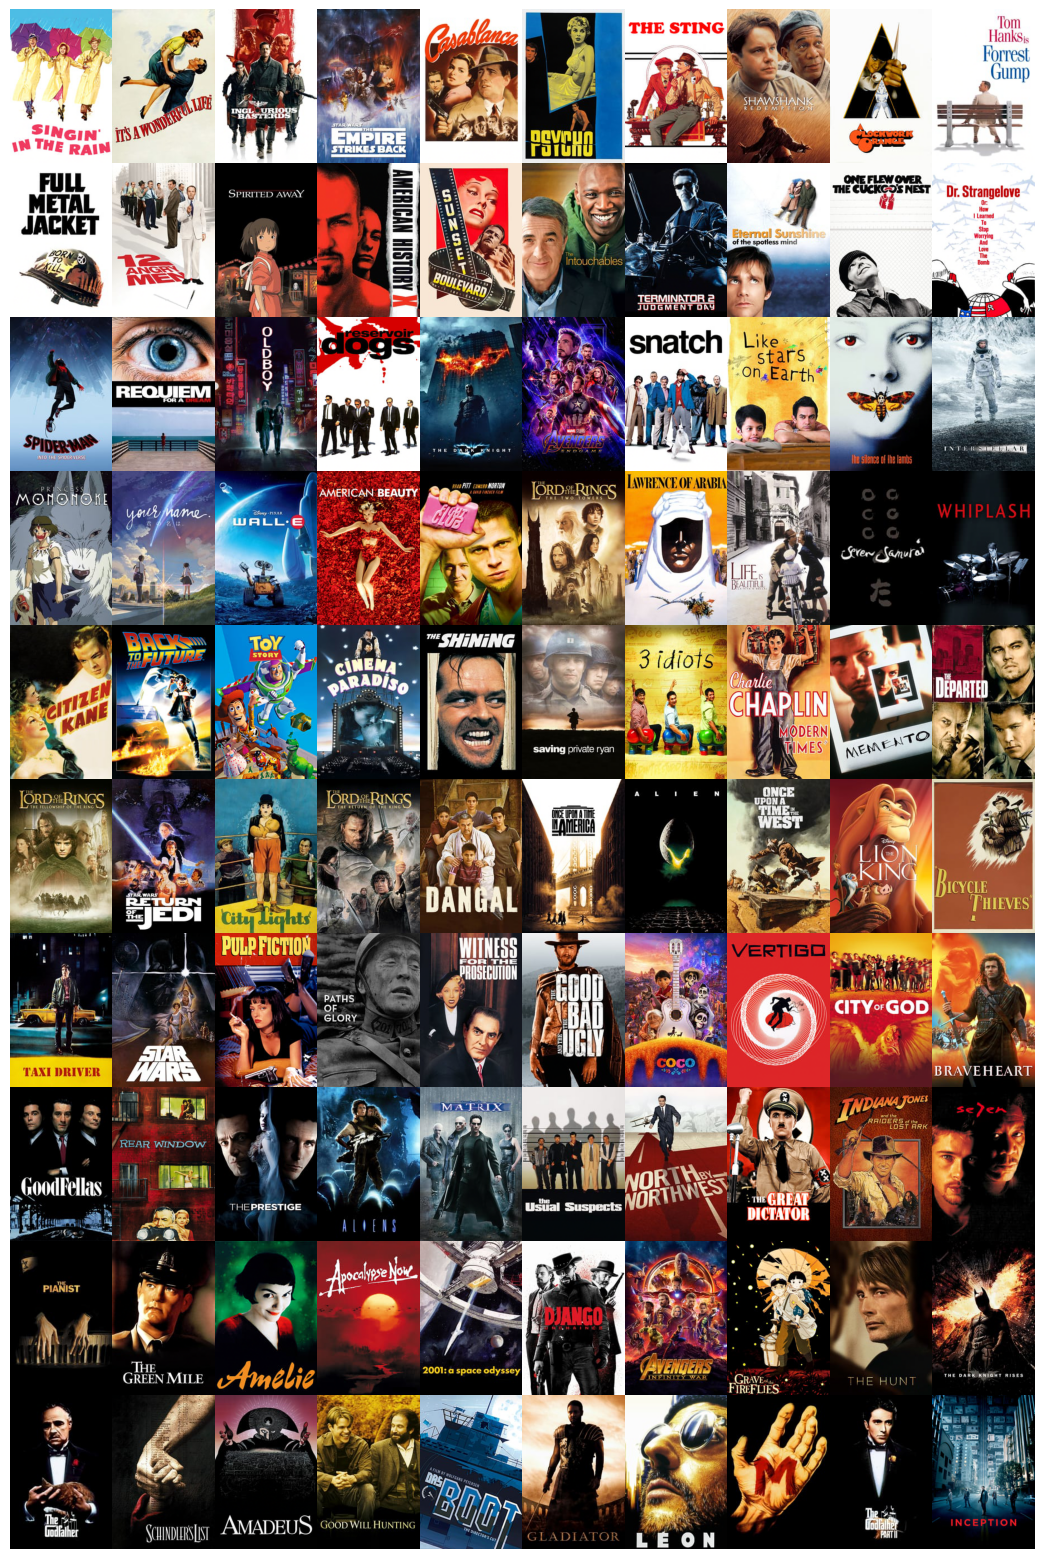

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(h, w), axes_pad=0)

def place_image(i, img):
    img = (scaler.inverse_transform(img.reshape(1, -1))).astype(int)
    grid[i].imshow(img.reshape(original_shape))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(w*h):
    position = np.unravel_index(i, (h, w))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (h, w))
    img = collided.pop()
    place_image(i, img)

plt.show()

# ⭕ Ejemplo 5: Clustering

Usaremos el dataset [seeds](https://archive.ics.uci.edu/dataset/236/seeds), el cual consta de 210 mediciones de 3 diferentes especies de trigo.

El objetivo del ejercicio es definir y entrenar una red SOM para hacer clustering en este dataset. Debemos encontrar 3 clusters.

* Prueba con diferentes combinaciones de hiperparámetros para la red.
* Prueba con diferentes combinaciones de features. Al final, prueba con las features 0 y 5.

Al final graficaremos los clusters junto con las instancias.

Preparamos los datos

In [ ]:
from minisom import MiniSom
import numpy as np
import pandas as pd

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'],
                #    usecols=[0, 5],
                   sep='\t+', engine='python')

data

Estandarizamos los datos

In [ ]:
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

Definimos la red

In [ ]:
som_rows =
som_cols =

num_features =

som = MiniSom(som_rows, som_cols, num_features,
              sigma=,
              learning_rate=,
              neighborhood_function='gaussian',
              random_seed=10)

Entrenamos la red

In [ ]:
som.train_batch(data, 500, verbose=True)

In [ ]:
winner_coordinates = np.array([som.winner(x) for x in data]).T

som_shape = (som_rows,som_cols)

cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

Graficamos cada cluster de un color diferente.

* Las coordenadas de cada centroide son las primeras dos coordenadas de cada vector de pesos.
* Las coordenadas de cada punto del dataset son las primeras dos coordenadas de los datos de entrada.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Datos
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Centroides
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x',
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();